In [25]:

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

from skopt.space import Categorical

# mis importaciones 
import pandas as pd
import seaborn as sns
import yaml
import datetime
import numpy as np
import os
# Fijar la semilla para reproducibilidad
seed = 42  
torch.manual_seed(seed)
np.random.seed(seed)


# Datos

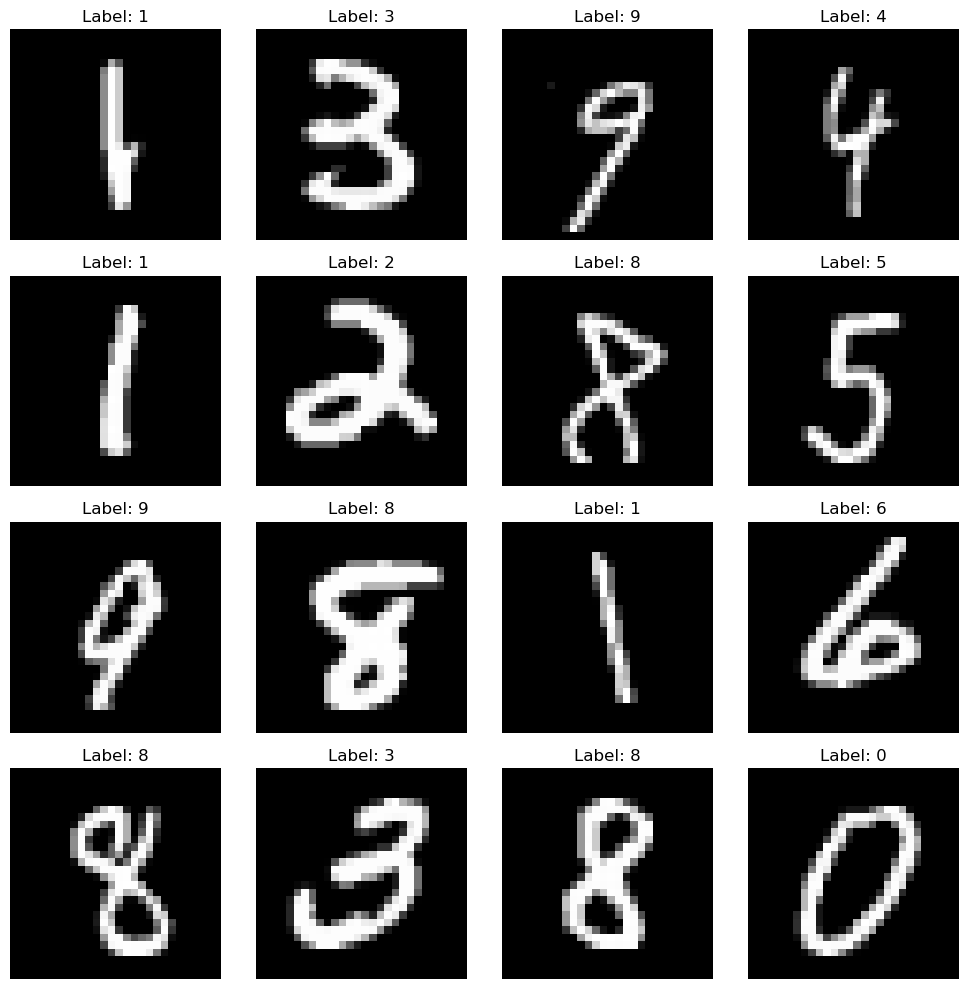

In [14]:

# Load MNIST dataset
# Definimos una secuencia de transformaciones para aplicar a las imágenes del dataset.
# En este caso, solo convertimos las imágenes a tensores utilizando `ToTensor()`.
# Esto es necesario para que las imágenes estén en un formato compatible con PyTorch.
transform = transforms.Compose([
    transforms.ToTensor()  # Convierte la imagen de un formato PIL o numpy.ndarray a un tensor.
])

# Cargamos el dataset MNIST de entrenamiento.
# `root='./data'` especifica el directorio donde se descargarán los datos si no están presentes.
# `train=True` indica que queremos el conjunto de datos de entrenamiento.
# `transform=transform` aplica las transformaciones definidas previamente a cada imagen.
# `download=True` descarga los datos si no están disponibles en el directorio especificado.
mnist_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

# Creamos un DataLoader que nos permite cargar los datos en lotes pequeños.
# `dataset=mnist_dataset` es el dataset que se cargará.
# `batch_size=16` indica que cada lote contendrá 16 imágenes y etiquetas.
# `shuffle=True` mezcla los datos aleatoriamente en cada época, mejorando la generalización del modelo.
data_loader = DataLoader(
    mnist_dataset, batch_size=16, shuffle=True
)

# Obtenemos un único lote de datos del DataLoader.
# `next(iter(data_loader))` convierte el DataLoader en un iterador y toma el primer lote.
# El lote contiene `images` (los tensores de las imágenes) y `labels` (las etiquetas correspondientes).
images, labels = next(iter(data_loader))


# Plot the images in a grid
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Arquitectura

In [15]:

# Definimos el modelo MLP
# MLP hereda de nn.Module, lo que permite utilizar las funciones y propiedades de PyTorch
# para crear, entrenar y evaluar redes neuronales.
class MLP(nn.Module):
    def __init__(self):
        # Inicializamos la clase base nn.Module
        # Esto habilita funciones esenciales como la gestión de capas y forward pass.
        super(MLP, self).__init__()
        # Capa completamente conectada: de entrada (28x28 píxeles) a 512 neuronas
        self.fc1 = nn.Linear(28 * 28, 200)
        # Capa oculta: de 512 neuronas a 256 neuronas
        self.fc2 = nn.Linear(200, 256)
        # Capa de salida: de 256 neuronas a 10 clases (números del 0 al 9)
        self.fc3 = nn.Linear(256, 10)
        
        #self.fc4 = nn.Linear(10, 10)
        # Función de activación ReLU
        self.relu = nn.ReLU()
        # Dropout para evitar sobreajuste
        self.dropout = nn.Dropout(0.2)

    # Definimos cómo pasa la información a través de la red
    # Este método es obligatorio en las clases que heredan de nn.Module.
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplanamos las imágenes (de 28x28 a 1D)
        x = self.relu(self.fc1(x))  # Aplicamos la primera capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.relu(self.fc2(x))  # Aplicamos la segunda capa y ReLU
        x = self.dropout(x)         # Aplicamos Dropout
        x = self.fc3(x)             # Aplicamos la capa de salida
        return x

# Entrenamiento

In [16]:
# Hiperparámetros
batch_size = 64       # Tamaño de lote
learning_rate = 0.001 # Tasa de aprendizaje
epochs = 10           # Número de épocas de entrenamiento

# Preprocesamiento y carga de datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

# Definimos el modelo, la función de pérdida y el optimizador
model = MLP()                             # Creamos una instancia del modelo MLP
criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizador Adam

# Bucle de entrenamiento
for epoch in range(epochs):
    model.train()  # Ponemos el modelo en modo entrenamiento
    for images, labels in train_loader:  # Iteramos sobre lotes de datos
        optimizer.zero_grad()            # Reiniciamos los gradientes
        outputs = model(images)          # Hacemos una predicción con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()                  # Propagamos los gradientes
        optimizer.step()                 # Actualizamos los pesos del modelo

    # Mostramos la pérdida al final de cada época
    print(f"Época [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}")



Época [1/10], Pérdida: 0.1605
Época [2/10], Pérdida: 0.1608
Época [3/10], Pérdida: 0.5540
Época [4/10], Pérdida: 0.0715
Época [5/10], Pérdida: 0.2728
Época [6/10], Pérdida: 0.0721
Época [7/10], Pérdida: 0.0461
Época [8/10], Pérdida: 0.0125
Época [9/10], Pérdida: 0.1574
Época [10/10], Pérdida: 0.0040


# Evaluación del modelo

In [17]:
model.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
correct = 0
total = 0
with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
    for images, labels in test_loader:  # Iteramos sobre los datos de prueba
        outputs = model(images)         # Hacemos predicciones
        _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
        total += labels.size(0)         # Total de muestras evaluadas
        correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

# Calculamos y mostramos la precisión del modelo
accuracy = 100 * correct / total
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")

Accuracy en el conjunto de prueba: 97.37%


# Mis funciones para guardar datos



In [26]:
#######################################    
# Guardar resultados en un archivo YAML    
def guardar_resultados_yaml(parametros, hiperparametros,  accuracy, performance, nombre_archivo):
    hr = datetime.datetime.now().strftime("%y-%m-%d_%f")  
    # Convertir todos los valores de parámetros a nativos antes de guardar, parametros es un diccionario
    parametros = {k: convertir_a_nativo(v) for k, v in parametros.items()}
    hiperparametros = {k: convertir_a_nativo(v) for k, v in hiperparametros.items()}
    
    
    resultados = {
        'timestamp': hr,
        'resultado' : {
            'parametros': parametros,
            'hiperparametros': hiperparametros,
            'accuracy': accuracy, 
            'performance': performance
        }
    }
      
    if not os.path.exists('respuesta'):
        os.makedirs('respuesta')
    ruta_file = f'respuesta/{nombre_archivo}'
    
    # cargar los datos existentes en el archivo YAML
    try:
        with open(ruta_file, 'r') as file:
            old_respuesta = yaml.safe_load(file)
            if old_respuesta is None:
                old_respuesta = []
    except FileNotFoundError:
        old_respuesta = []

    old_respuesta.append(resultados)
    
    with open(ruta_file, 'w') as file:
        yaml.dump(old_respuesta, file, default_flow_style=False, allow_unicode=True)

##############################
# Leer resuladaos de un archivo YAML y ponerlos en un dataframe
def leer_resultados(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        resultados = yaml.safe_load(file)
    
    # Convertir los resultados en una lista de diccionarios
    filas = []
    for entrada in resultados:
        resultado = entrada['resultado']
        fila = {
            'timestamp': entrada['timestamp'],
            'accuracy': resultado['accuracy'],
            'performance': resultado['performance'],
            **resultado['hiperparametros'],  # Desempaquetar los hiperparámetros
            **resultado['parametros'],      # Desempaquetar los parámetros
        }
        filas.append(fila)

    # Crear el DataFrame a partir de las filas
    df = pd.DataFrame(filas)
    return df


#######################    
def escribir_label(x):
    return 'Res:' + str(x)[-6:]
#######################

# Reorganizar y regenerar el dataframe
def reorganizar_dataframe_comprimido(df):
    df_comprimido = df.loc[df.groupby('timestamp')['accuracy'].idxmax()] # Obtener el máximo accuracy por timestamp con idxmax indicando la fila
    df_comprimido = df_comprimido.reset_index(drop=True)
    # genero las columnas de parametros y hiperparametros para el dataframe comprimido
    df_comprimido['parametros'] = (
        "f_l1:" + df_comprimido['filters_l1'].astype(str) + " - " +
        "f_l2:" + df_comprimido['filters_l2'].astype(str) + " - " +
        "drp:" + df_comprimido['dropout'].astype(str) + " - " +
        "fi_lay:" + df_comprimido['final_layer_size'].astype(str)
    )
    df_comprimido['hiperparametros'] = (
        "op_fn:" + df_comprimido['optimizer_str'].astype(str) + " - " +
        "lr:" + df_comprimido['learning_rate'].astype(str) + " - " +
        "e:" + df_comprimido['num_epochs'].astype(str)
    )
    # como no me cupo en el gráfico, genero una etiqueta más corta
    df_comprimido['label'] = df_comprimido['timestamp'].apply(lambda x: escribir_label(x))
    
    df_final = df_comprimido[['label', 'accuracy', 'performance','parametros', 'hiperparametros','timestamp']]
    

    return df_final    
    
######################
# Función para calcular el tiempo de performance
def calcular_performance(timestamp_1, timestamp_2):
    return (timestamp_2 - timestamp_1).total_seconds() /60

def convertir_a_nativo(obj):
    """Convierte valores numpy a tipos nativos de Python."""
    if isinstance(obj, (np.int64, np.int32)):  # Números enteros
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):  # Números de punto flotante
        return float(obj)
    elif isinstance(obj, np.ndarray):  # Arreglos de numpy
        return obj.tolist()  # Convertir a lista
    else:
        return obj  # Dejar otros tipos sin cambios

######################
# Convertir a horas y minutos
def convertir_MM_SS(total_minutos):
    # total_seconds = int(total_seconds
    minutes = int(total_minutos % 60)  # Minutos restantes
    segundos = int((total_minutos % 1) * 60)  # Segundos restantes
    milisegundos = int(((total_minutos % 1) * 60 % 1) * 1000)  # Milisegundos restantes
    res = f"{minutes:02d}:{segundos:02d},{milisegundos:03d}"  # Formato HH:MM:SS,ms
    return res

######################
def graficar_accuracy_vs_performance(df):
    # Datos
    modelos = df['label']
    accuracy = df['accuracy']
    performance = df['performance']

    # Crear la figura y el primer eje Y
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Gráfico de barras para accuracy con Seaborn
    color1 = '#a90dee'  # morado
    sns.barplot(x=modelos, y=accuracy, ax=ax1, color=color1, edgecolor='black')
    ax1.set_ylabel('Accuracy (%)', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)

    # Mostrar valores encima de las barras de accuracy
    for i, val in enumerate(accuracy):
        ax1.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=8, color=color1)

    # Crear el segundo eje Y
    ax2 = ax1.twinx()
    color2 = '#37a3ff'  # azul
    color_l2 = '#002986'  # azul oscuro para los valores x debajo de las barras
    sns.barplot(x=modelos, y=performance, ax=ax2, color=color2, edgecolor='black', alpha=0.7)
    ax2.set_ylabel('Performance (min)', color=color_l2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color_l2)

    # Mostrar valores por debajo de las barras de performance
    for i, val in enumerate(performance):
        ax2.text(i, val - (val * 0.05), f'{val:.2f}', ha='center', fontsize=10, color=color_l2)

    # Etiquetas y título
    ax1.set_xticks(np.arange(len(modelos)))
    ax1.set_xticklabels(modelos, rotation=45, ha='right', fontsize=10)
    plt.title('Comparación de Accuracy y Performance por Modelo', fontsize=14)
    plt.tight_layout()
    plt.show()
    
def reorganizar_columnas(df, lista_col):
    # Seleccionar las columnas en el orden de la lista
    columnas_reorganizadas = [col for col in lista_col if col in df.columns]
    # Agregar las columnas restantes que no están en la lista
    columnas_resto = [col for col in df.columns if col not in lista_col]
    # Reorganizar las columnas
    return df[columnas_reorganizadas + columnas_resto]


########################
import textwrap
pd.options.mode.copy_on_write = True 
# Graficar accuracy vs parámetros (con barras de diferentes colores)
def graficar_accuracy_parametros(df, nombre_col):
    plt.figure(figsize=(10, 6))
    etiquetas = [textwrap.fill(str(x), width=20) for x in df[nombre_col]]  # Dividir etiquetas largas
    bars = plt.bar(etiquetas, df['accuracy'], color=plt.cm.tab10.colors, edgecolor='black')

    # Personalizar la gráfica
    plt.title("Accuracy vs Set de Parámetros e Hiperparámetros", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xlabel("Set Parámetros e Hiperparámetros", fontsize=12)
    plt.xticks(rotation=45, fontsize=8)
    plt.grid(visible=True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Mostrar valores encima de cada barra
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f'{bar.get_height():.4f}', ha='center', fontsize=8)

    plt.show()
    
###################
# Reorganizar los resultados para graficarlos
def reorganizar_graficar_save(df_resultados, nombre_archivo):
    #reorganizar y regenerar el dataframe, de forma de tener un solo registro por timestamp en el maximo accuracy
    df_final = reorganizar_dataframe_comprimido(df_resultados)
    df_final['performance_min'] = df_final['performance'].apply(convertir_MM_SS)
    df_final = df_final.sort_values(by='accuracy', ascending=False)
    graficar_accuracy_parametros(df_final, 'label')
    max_index_accuracy = df_final['accuracy'].idxmax()
    respuesta_final = f'El mejor modelo es el set de {df_final.loc[max_index_accuracy, "label"]} con los parámetros  {df_final.loc[max_index_accuracy, "parametros"]} \n' +f'con un accuracy de {df_final.loc[max_index_accuracy, "accuracy"]:.2f}% y Performance de {df_final.loc[max_index_accuracy, "performance_min"]} minutos, \n' +f'con los hiperparámetros {df_final.loc[max_index_accuracy, "hiperparametros"]}'
    print(respuesta_final)
    # exportar el dataframe a un archivo csv, saque la performance porque lo tengo en minutos y segundos, y las ordené a mi gusto
    df_exportar = df_final.drop(columns=['performance'])
    df_exportar = reorganizar_columnas(df_exportar, ['label', 'accuracy', 'performance_min', 'parametros', 'hiperparametros'])
    ruta = f'respuesta/' + nombre_archivo
    exportar = df_exportar.to_csv(ruta, sep=';', index=False)
    return df_final
    


# Capas convolucionales

In [27]:

# Declaración de la clase CNN

class CNN(nn.Module):
    def __init__(self, verbose=False, filters_l1=32, filters_l2=64, dropout=0.2, final_layer_size=128):
        super(CNN, self).__init__()
        self.verbose = verbose
        self.filters_l1 = filters_l1
        self.filters_l2 = filters_l2
        self.dropout_rate = dropout
        self.final_layer_size = final_layer_size

        # Primera capa convolucional
        self.conv1 = nn.Conv2d(1, self.filters_l1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(self.filters_l1, self.filters_l2, kernel_size=3, stride=1, padding=1)

        # Calcular automáticamente las dimensiones de la capa lineal (fc1)
        self.fc1_input_size = self._calculate_fc1_input_size()
        
        # Primera capa completamente conectada
        self.fc1 = nn.Linear(self.fc1_input_size, self.final_layer_size)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.final_layer_size, 10)  # Capa de salida para 10 clases (MNIST)

    def _calculate_fc1_input_size(self):
        """
        Calcula automáticamente el tamaño de la entrada para la primera capa completamente conectada (fc1).
        Simula una pasada con una imagen de prueba de tamaño (1, 28, 28).
        """
        with torch.no_grad():  # Desactiva gradientes
            x = torch.randn(1, 1, 28, 28)  # Tensor ficticio de entrada con tamaño MNIST (batch_size=1)
            x = self.pool(torch.relu(self.conv1(x)))  # Aplicar Conv1 -> Pool
            x = self.pool(torch.relu(self.conv2(x)))  # Aplicar Conv2 -> Pool
            fc1_input_size = x.numel()  # Calcular número total de elementos
        return fc1_input_size

    def forward(self, x):
        if self.verbose: 
            print(f"Entrada: {x.shape}")  # Imprime la dimensión de la entrada

        # Primera capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv1(x)))
        if self.verbose:
            print(f"Después de Conv1 y MaxPooling: {x.shape}")  # Dimensión después de Conv1 y Pool

        # Segunda capa convolucional, ReLU y MaxPooling
        x = self.pool(torch.relu(self.conv2(x)))
        if self.verbose:
            print(f"Después de Conv2 y MaxPooling: {x.shape}")  # Dimensión después de Conv2 y Pool

        # Aplanar las características 2D a 1D
        x = x.view(-1, self.fc1_input_size)
        if self.verbose:
            print(f"Después de Aplanamiento: {x.shape}")  # Dimensión después de Flatten

        # Primera capa completamente conectada
        x = torch.relu(self.fc1(x))
        if self.verbose:
            print(f"Después de Fully Connected (fc1): {x.shape}")  # Dimensión después de fc1

        # Aplicar Dropout
        x = self.dropout(x)
        if self.verbose:
            print(f"Después de Dropout: {x.shape}")  # Dimensión después de Dropout

        # Capa de salida
        x = self.fc2(x)
        if self.verbose:
            print(f"Después de Fully Connected (fc2): {x.shape}")  # Dimensión después de fc2 (salida final)

        return x



In [28]:

# Preprocesamiento: Definir transformaciones para los datos
transform = transforms.Compose([
    transforms.ToTensor(),                # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores a un rango de [-1, 1]
])

# Cargar el conjunto de datos MNIST, se pueden ver dentro de otras funciones pq están definidas como ámbito global
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)  # Datos de entrenamiento
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)  # Datos de prueba

# Funcion Crear DataLoaders para manejar los datos de forma eficiente
batch_size = 128  # Tamaño de lote
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader de entrenamiento
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  # DataLoader de prueba


# Parte 1 : Modificando los Parámetros 

## Usaré la Bayesian Hyperparameter Optimization seleccionar los mejores parámetros 

Ver tutorial [aquí](https://wandb.ai/wandb_fc/articles/reports/What-Is-Bayesian-Hyperparameter-Optimization-With-Tutorial---Vmlldzo1NDQyNzcw)

Según las indicaciones por correo del profesor .. por tiempo sería mejor ver con esta optimización cuales son las mejores combinaciones de parámetros e hiperparámetros 

In [11]:
# lista de paramatros para el modelo CNN
lista_filters_l1 = [8, 32, 64]
lista_filters_l2 = [32, 64, 128]
lista_final_layer_size = [30, 100, 200]
lista_dropout = [0.2, 0.3, 0.4]

# Definir el espacio de búsqueda categórico
espacio_parametros = [
    Categorical([8, 32, 64], name="filters_l1"),           # Valores específicos para filtros de capa 1
    Categorical([32, 64, 128], name="filters_l2"),         # Valores específicos para filtros de capa 2
    Categorical([30, 100, 200], name="final_layer_size"),  # Tamaños específicos de la capa final
    Categorical([0.2, 0.3, 0.4], name="dropout")           # Valores específicos para dropout
]

In [18]:
# Verificar si hay una GPU disponible, de lo contrario usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definir la funcion objetivo

@use_named_args(espacio_parametros)
def funcion_objetivo(filters_l1, filters_l2, final_layer_size, dropout):
    # Hiperparámetros
    num_epochs = 10  # Número de épocas
    learning_rate =0.001
    optimizer_str = 'Adam'
    optimizer_fn = getattr(optim, optimizer_str)
    
    
    print(f"Probar combinación: filters_l1={filters_l1}, filters_l2={filters_l2}, "
          f"final_layer_size={final_layer_size}, dropout={dropout}")
    
    # timestamp inicial para la performance  
    timestamp_1 = datetime.datetime.now()
    print(f'Comienza a procesar el modelo en: {timestamp_1}')
    
    # Inicializar el modelo, la función de pérdida y el optimizador
    model = CNN(verbose=False, filters_l1=filters_l1, filters_l2=filters_l2, dropout=dropout, final_layer_size=final_layer_size).to(device)                             # Mover el modelo a la GPU/CPU
    criterion = nn.CrossEntropyLoss()                    # Función de pérdida para clasificación multiclase
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate) # Optimizador Adam con tasa de aprendizaje 0.001
    
    # Bucle principal de entrenamiento
    
    for epoch in range(num_epochs):
        # Entrenar el modelo y calcular la pérdida
        train_loss = train(model, train_loader, criterion, optimizer, device)
        # Evaluar el modelo en el conjunto de prueba
        test_accuracy = evaluate(model, test_loader, device)
        # Imprimir los resultados de la época actual
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
    # timestamp final para la performance    
    timestamp_2 = datetime.datetime.now() 
    print(f'Termina el procesamiento del modelo a: {timestamp_2}')
       
    # Calcular la precisión final en el conjunto de prueba
    final_accuracy = evaluate(model, test_loader, device)
    print(f"Final Test Accuracy: {final_accuracy:.4f}")
    
    
    performance = calcular_performance(timestamp_1, timestamp_2)
    print(f'Performance: {performance:.2f} minutos')
    
    # guardar los resultados en un archivo YAML
    param_dict = {'filters_l1': filters_l1, 'filters_l2': filters_l2, 'final_layer_size': final_layer_size, 'dropout': dropout} 
    hiper_dict = {'num_epochs': num_epochs, 'learning_rate': learning_rate, 'optimizer_str': optimizer_str} 
    
    guardar_resultados_yaml(param_dict, hiper_dict, final_accuracy, performance, 'resultados_cnn.yaml')
    
    return -final_accuracy  # Devolver la precisión negativa para minimizar

# Definir la función de entrenamiento
def train(model, loader, criterion, optimizer, device):
    model.train()  # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0
    for images, labels in loader:  # Iterar sobre los lotes de datos
        images, labels = images.to(device), labels.to(device)  # Mover los datos a la GPU/CPU

        optimizer.zero_grad()       # Reiniciar los gradientes
        outputs = model(images)     # Paso hacia adelante
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()             # Paso hacia atrás (cálculo de gradientes)
        optimizer.step()            # Actualizar los pesos

        running_loss += loss.item()  # Acumular la pérdida
    return running_loss / len(loader)  # Devolver la pérdida promedio

# Definir la función de evaluación
def evaluate(model, loader, device):
    model.eval()  # Establecer el modelo en modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes para ahorrar memoria
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a la GPU/CPU
            outputs = model(images)  # Paso hacia adelante
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones (clase con mayor probabilidad)
            total += labels.size(0)  # Contar el número total de ejemplos
            correct += (predicted == labels).sum().item()  # Contar las predicciones correctas
    return correct / total  # Calcular la precisión




Aquí se ejecuta la mejor optamizacion bayesiana de estos parametros

In [19]:
timestamp_1 = datetime.datetime.now()
# Ejecutar la optimización bayesiana
resultado = gp_minimize(
    func=funcion_objetivo,
    dimensions=espacio_parametros,
    n_calls=10,         # Número de combinaciones a probar
    random_state=42     # Para reproducibilidad
)
timestamp_2 = datetime.datetime.now()
tpo_ejecucion = calcular_performance(timestamp_1, timestamp_2)
print(f'Tiempo de ejecución Op.Bayesiana: {tpo_ejecucion:.2f} minutos')

Probar combinación: filters_l1=64, filters_l2=32, final_layer_size=200, dropout=0.3
Comienza a procesar el modelo en: 2024-12-20 23:50:28.027025
Epoch [1/10], Loss: 0.2245, Test Accuracy: 0.9825
Epoch [2/10], Loss: 0.0625, Test Accuracy: 0.9884
Epoch [3/10], Loss: 0.0444, Test Accuracy: 0.9902
Epoch [4/10], Loss: 0.0370, Test Accuracy: 0.9908
Epoch [5/10], Loss: 0.0305, Test Accuracy: 0.9907
Epoch [6/10], Loss: 0.0255, Test Accuracy: 0.9918
Epoch [7/10], Loss: 0.0214, Test Accuracy: 0.9906
Epoch [8/10], Loss: 0.0199, Test Accuracy: 0.9919
Epoch [9/10], Loss: 0.0164, Test Accuracy: 0.9918
Epoch [10/10], Loss: 0.0153, Test Accuracy: 0.9925
Termina el procesamiento del modelo a: 2024-12-20 23:57:23.515028
Final Test Accuracy: 0.9925
Performance: 6.92 minutos
Probar combinación: filters_l1=32, filters_l2=32, final_layer_size=100, dropout=0.3
Comienza a procesar el modelo en: 2024-12-20 23:57:27.220053
Epoch [1/10], Loss: 0.3135, Test Accuracy: 0.9785
Epoch [2/10], Loss: 0.0907, Test Accura

In [20]:
print("Mejor combinación de parámetros:")
mejor_combinacion = {
    "filters_l1": resultado.x[0],
    "filters_l2": resultado.x[1],
    "final_layer_size": resultado.x[2],
    "dropout": resultado.x[3]
}
print(mejor_combinacion)

print(f"Mejor precisión obtenida: {-resultado.fun:.4f}")

Mejor combinación de parámetros:
{'filters_l1': 32, 'filters_l2': 128, 'final_layer_size': 200, 'dropout': 0.3}
Mejor precisión obtenida: 0.9930


## Leer resultados guardados YAML de la Optimización Bayesiana

Esto es para mostrar gráficamente que encontramos el mejor resultado según lo indicado arriba, pero con una respresentación gráfica, parpa los parámatros, filters_l1, filters_l2, final_layer_size, dropout.

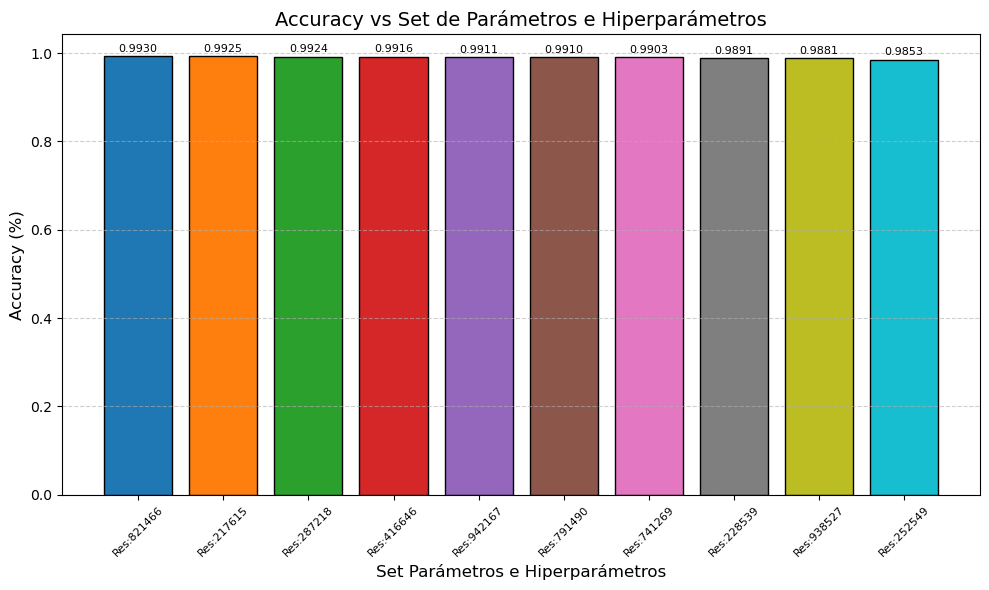

El mejor modelo es el set de Res:821466 con los parámetros  f_l1:32 - f_l2:128 - drp:0.3 - fi_lay:200 
con un accuracy de 0.99% y Performance de 08:46,787 minutos, 
con los hiperparámetros op_fn:Adam - lr:0.001 - e:10


,label,accuracy,performance,parametros,hiperparametros,timestamp,performance_min
7,Res:821466,0.9930,8.779786,f_l1:32 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:Adam - lr:0.001 - e:10,24-12-21_821466,"08:46,787"
0,Res:217615,0.9925,6.924800,f_l1:64 - f_l2:32 - drp:0.3 - fi_lay:200,op_fn:Adam - lr:0.001 - e:10,24-12-20_217615,"06:55,488"
3,Res:287218,0.9924,7.422484,f_l1:64 - f_l2:32 - drp:0.3 - fi_lay:200,op_fn:Adam - lr:0.001 - e:10,24-12-21_287218,"07:25,349"
4,Res:416646,0.9916,4.937769,f_l1:32 - f_l2:32 - drp:0.2 - fi_lay:200,op_fn:Adam - lr:0.001 - e:10,24-12-21_416646,"04:56,266"
9,Res:942167,0.9911,4.515817,f_l1:32 - f_l2:32 - drp:0.3 - fi_lay:100,op_fn:Adam - lr:0.001 - e:10,24-12-21_942167,"04:30,949"
6,Res:791490,0.9910,3.799720,f_l1:8 - f_l2:64 - drp:0.4 - fi_lay:100,op_fn:Adam - lr:0.001 - e:10,24-12-21_791490,"03:47,983"
5,Res:741269,0.9903,5.199079,f_l1:8 - f_l2:128 - drp:0.3 - fi_lay:100,op_fn:Adam - lr:0.001 - e:10,24-12-21_741269,"05:11,944"
1,Res:228539,0.9891,4.750878,f_l1:32 - f_l2:32 - drp:0.3 - fi_lay:30,op_fn:Adam - lr:0.001 - e:10,24-12-21_228539,"04:45,052"
8,Res:938527,0.9881,3.643876,f_l1:8 - f_l2:64 - drp:0.4 - fi_lay:30,op_fn:Adam - lr:0.001 - e:10,24-12-21_938527,"03:38,632"
2,Res:252549,0.9853,3.056587,f_l1:8 - f_l2:32 - drp:0.4 - fi_lay:30,op_fn:Adam - lr:0.001 - e:10,24-12-21_252549,"03:03,395"


In [21]:
# Aquí vamos a recuperar lo hemos guardado en el archivo YAML, de la función anterior y lo vamos a poner en un dataframe
df_resultados = leer_resultados('respuesta/resultados_cnn.yaml')

df_final = reorganizar_graficar_save(df_resultados, 'resultados_cnn.csv')

df_final

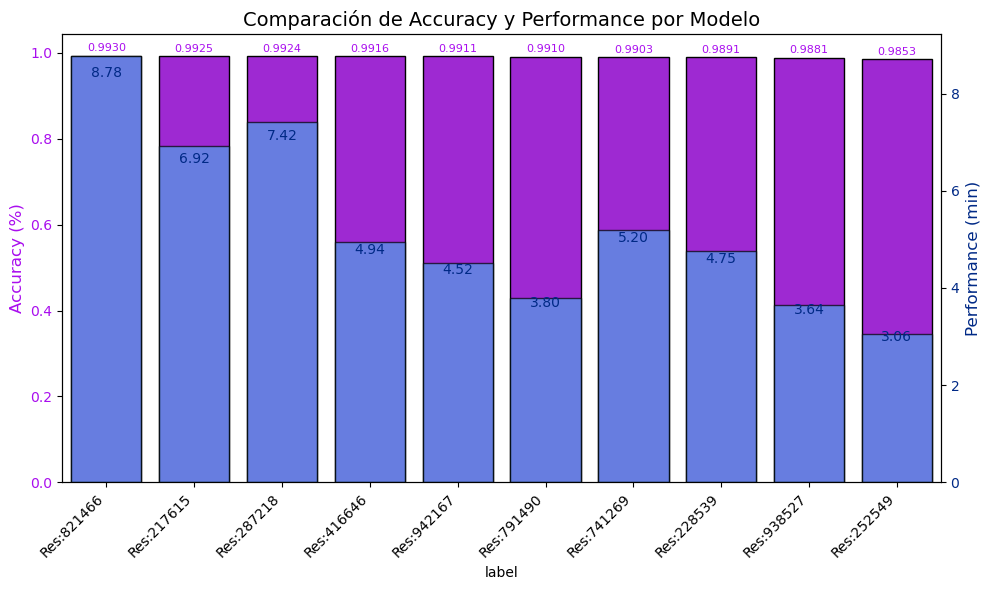

In [22]:

graficar_accuracy_vs_performance(df_final)


# Parte 2 donde variamos los hiperparámetros 


In [35]:

# según el resultadno anterior, se puede indicar que este fue el mejor resultado
best_param = {'filters_l1': 34, 'filters_l2': 128, 'final_layer_size': 200, 'dropout': 0.3}
# Espacio de búsqueda para los hiperparámetros
espacio_hiperparametros = [
    Categorical([0.1, 0.01, 0.001, 0.0001], name="learning_rate"),  # Tasa de aprendizaje para el optimizador
    Categorical(['Adam', 'SGD', 'RMSprop', 'Adagrad'], name="optimizer_str")  # Optimizadores disponibles
]

In [38]:
# Verificar si hay una GPU disponible, de lo contrario usar la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir la Función Objetivo para Hiperparámetros en CNN
@use_named_args(espacio_hiperparametros)
def funcion_objetivo_hiper(learning_rate, optimizer_str):
    print(f"Probar combinación: learning_rate={learning_rate}, optimizer_str={optimizer_str}")
    
    # se dejan aqui el mejor resultado obtenido de la iteracion anterior
    best_param = {'filters_l1': 34, 'filters_l2': 128, 'final_layer_size': 200, 'dropout': 0.3}
    
    # Hiperparámetros
    num_epochs = 10  # Número de épocas
    optimizer_fn = getattr(optim, optimizer_str) # Obtener la función del optimizador
    
    
    
    # timestamp inicial para la performance  
    timestamp_1 = datetime.datetime.now()
    print(f'Comienza a procesar el modelo en: {timestamp_1}')
    
    # Inicializar el modelo, la función de pérdida y el optimizador
    model = CNN(verbose=False, filters_l1=best_param['filters_l1'], filters_l2=best_param['filters_l2'], dropout=best_param['dropout'], final_layer_size=best_param['final_layer_size']).to(device)    # Mover el modelo a la GPU/CPU
    criterion = nn.CrossEntropyLoss()                    # Función de pérdida para clasificación multiclase
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate) # Optimizador Adam con tasa de aprendizaje 0.001
    
    # Bucle principal de entrenamiento
    
    for epoch in range(num_epochs):
        # Entrenar el modelo y calcular la pérdida
        train_loss = train(model, train_loader, criterion, optimizer, device)
        # Evaluar el modelo en el conjunto de prueba
        test_accuracy = evaluate(model, test_loader, device)
        # Imprimir los resultados de la época actual
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
    # timestamp final para la performance    
    timestamp_2 = datetime.datetime.now() 
    print(f'Termina el procesamiento del modelo a: {timestamp_2}')
       
    # Calcular la precisión final en el conjunto de prueba
    final_accuracy = evaluate(model, test_loader, device)
    print(f"Final Test Accuracy: {final_accuracy:.4f}")
    
    
    performance = calcular_performance(timestamp_1, timestamp_2)
    print(f'Performance: {performance:.2f} minutos')
    
    # guardar los resultados en un archivo YAML
    param_dict = {'filters_l1': best_param['filters_l1'], 'filters_l2': best_param['filters_l2'], 'final_layer_size': best_param['final_layer_size'], 'dropout': best_param['dropout']} 
    hiper_dict = {'num_epochs': num_epochs, 'learning_rate': learning_rate, 'optimizer_str': optimizer_str} 
    
    guardar_resultados_yaml(param_dict, hiper_dict, final_accuracy, performance, 'resultados_cnn_hiper.yaml')
    
    return -final_accuracy  # Devolver la precisión negativa para minimizar

In [39]:
timestamp_1 = datetime.datetime.now()
# Ejecutar la optimización bayesiana
resultado_hiper = gp_minimize(
    func=funcion_objetivo_hiper,
    dimensions=espacio_hiperparametros,
    n_calls=10,         # Número de combinaciones a probar
    random_state=42     # Para reproducibilidad
)
timestamp_2 = datetime.datetime.now()
tpo_ejecucion = calcular_performance(timestamp_1, timestamp_2)


Probar combinación: learning_rate=0.0001, optimizer_str=Adam
Comienza a procesar el modelo en: 2024-12-21 04:33:57.645132
Epoch [1/10], Loss: 0.6025, Test Accuracy: 0.9518
Epoch [2/10], Loss: 0.1634, Test Accuracy: 0.9703
Epoch [3/10], Loss: 0.1079, Test Accuracy: 0.9795
Epoch [4/10], Loss: 0.0841, Test Accuracy: 0.9810
Epoch [5/10], Loss: 0.0710, Test Accuracy: 0.9844
Epoch [6/10], Loss: 0.0611, Test Accuracy: 0.9863
Epoch [7/10], Loss: 0.0545, Test Accuracy: 0.9866
Epoch [8/10], Loss: 0.0478, Test Accuracy: 0.9875
Epoch [9/10], Loss: 0.0434, Test Accuracy: 0.9891
Epoch [10/10], Loss: 0.0390, Test Accuracy: 0.9883
Termina el procesamiento del modelo a: 2024-12-21 04:43:12.141652
Final Test Accuracy: 0.9883
Performance: 9.24 minutos
Probar combinación: learning_rate=0.0001, optimizer_str=RMSprop
Comienza a procesar el modelo en: 2024-12-21 04:43:16.431606
Epoch [1/10], Loss: 0.3854, Test Accuracy: 0.9580
Epoch [2/10], Loss: 0.1362, Test Accuracy: 0.9762
Epoch [3/10], Loss: 0.0891, Test

In [43]:
print(f'Tiempo de ejecución Op.Bayesiana para hiperparámetros fue: {tpo_ejecucion:.2f} minutos')
print("Mejor combinación de hiperparámetros:")
mejor_combinacion_hiper = {
    "learning_rate": resultado_hiper.x[0],
    "optimizer_str": resultado_hiper.x[1]
}
print(mejor_combinacion_hiper)

print(f"Mejor precisión obtenida: {-resultado_hiper.fun:.4f}")

Tiempo de ejecución Op.Bayesiana para hiperparámetros fue: 94.52 minutos
Mejor combinación de hiperparámetros:
{'learning_rate': 0.001, 'optimizer_str': 'Adam'}
Mejor precisión obtenida: 0.9925


## Leer resultados guardados YAML de la Optimización Bayesiana para los hiperparámetros

Esto es para mostrar gráficamente que encontramos el mejor resultado según lo indicado arriba, pero con una respresentación gráfica, para los hiperparámatros: learning_rate, optimizer_str.

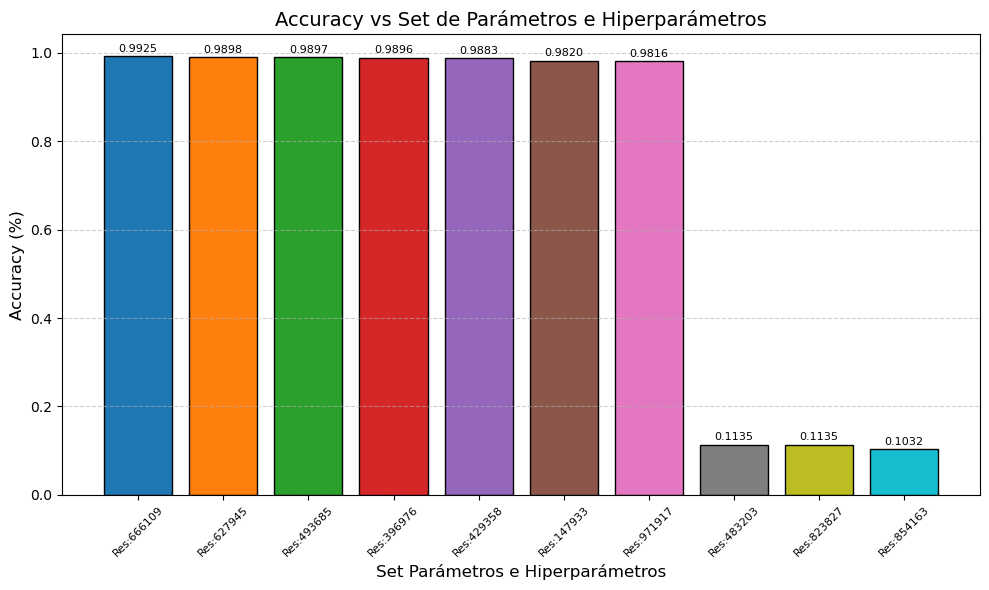

El mejor modelo es el set de Res:666109 con los parámetros  f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200 
con un accuracy de 0.99% y Performance de 08:48,960 minutos, 
con los hiperparámetros op_fn:Adam - lr:0.001 - e:10


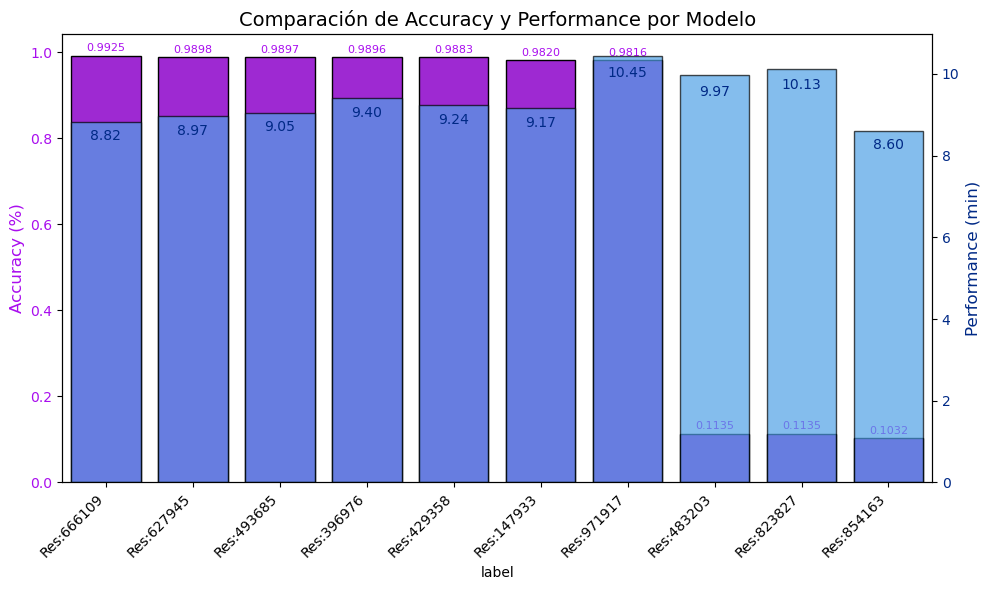

,label,accuracy,performance,parametros,hiperparametros,timestamp,performance_min
6,Res:666109,0.9925,8.816013,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:Adam - lr:0.001 - e:10,24-12-21_666109,"08:48,960"
5,Res:627945,0.9898,8.965351,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:RMSprop - lr:0.0001 - e:10,24-12-21_627945,"08:57,921"
4,Res:493685,0.9897,9.045570,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:RMSprop - lr:0.0001 - e:10,24-12-21_493685,"09:02,734"
1,Res:396976,0.9896,9.404330,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:Adam - lr:0.0001 - e:10,24-12-21_396976,"09:24,259"
2,Res:429358,0.9883,9.241609,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:Adam - lr:0.0001 - e:10,24-12-21_429358,"09:14,496"
0,Res:147933,0.9820,9.168212,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:Adam - lr:0.01 - e:10,24-12-21_147933,"09:10,092"
9,Res:971917,0.9816,10.447683,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:SGD - lr:0.01 - e:10,24-12-21_971917,"10:26,860"
3,Res:483203,0.1135,9.969681,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:RMSprop - lr:0.1 - e:10,24-12-21_483203,"09:58,180"
7,Res:823827,0.1135,10.130098,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:RMSprop - lr:0.1 - e:10,24-12-21_823827,"10:07,805"
8,Res:854163,0.1032,8.602945,f_l1:34 - f_l2:128 - drp:0.3 - fi_lay:200,op_fn:RMSprop - lr:0.1 - e:10,24-12-21_854163,"08:36,176"


In [44]:
# Aquí vamos a recuperar lo hemos guardado en el archivo YAML, de la función anterior y lo vamos a poner en un dataframe
df_resultados = leer_resultados('respuesta/resultados_cnn_hiper.yaml')

df_final_hiper = reorganizar_graficar_save(df_resultados, 'resultados_cnn_hiper.csv')

graficar_accuracy_vs_performance(df_final_hiper)

df_final_hiper

# 2.3 Compare el rendimiento, numero de parámetros y tiempo de ejecución. 
Personalmente encuentro que el tipo de ejecución para esto es larguísimo, traté de configurarlo de tal manera que fuera todo automatizado, para no estar de uno esperando cambiando los parámetros e hiperparámetros y visualizando con gráficos el resultado para que fuera más ilustrativo. 

La cantidad de parámetros que se le pasa la MLP es mucho mayor, lo que hace que la cantidad posible de combinaciones de éstas es mayor. Ahora el CUDA ayuda muchísimo a la rapidez de estas pruebas, donde modelos que se demoraban 8 minutos en promedio o más, después fue de 2 minutos. Puse ambos gráficos para su compresión y validación visual de ambas arquitecturas de redes neuronales. 

Lo analizaré por Rendimiento de Accuracy

En MNIST, un MLP tiene una precisión entre 97% y 98%, dependiendo de la cantidad de capas, neuronas y regularización. Una CNN puede superar fácilmente al MLP en precisión, alcanzando valores cercanos al 99%. La CNN ofrece un mejor rendimiento en MNIST gracias a su capacidad para explotar las propiedades espaciales de las imágenes, mientras que un MLP depende más de la cantidad de neuronas.

Ahora por número de Parámetros

Los parámetros en un MLP dependen directamente del tamaño de las capas y del número de neuronas, donde el número de parámetros crece rápidamente con el tamaño de las capas, mientras que las CNN pueden compartir capas, o algo así. Donde el uso eficiente de convoluciones y pooling hace que el número de número de parámetros significativamente menor para la misma tarea. 

Tiempo de Ejecución

El entrenamiento de un MLP puede ser más rápido porque no realiza operaciones convolucionales. Su tiempo de ejecución depende principalmente del tamaño del modelo y el número de épocas.

Sin embargo, el alto número de parámetros puede hacer que tarde más en converger en algunos casos, en mi caso mi computador se tardó muchísimo lo que me ha dado tiempo para realizar esta documentación. 

Se indica que las operaciones convolucionales son computacionalmente más intensivas que las multiplicaciones de matrices usadas en un MLP. Esto puede hacer que una CNN tome más tiempo por época en comparación con un MLP. Pero como tiene un menor número de parámetros y la mejor capacidad de generalización pueden reducir el tiempo necesario para alcanzar una buena precisión.

Por otro lado, la combinación de hiperparámetros por la Optimización Bayesiana, fue un gran alcance, porque fije que sea sólo 10 iteraciones aun así se demoró mas de 90 minutos en CNN. 

Conclusión sobre el tiempo de ejecución: El MLP puede ser más rápido por época, pero la CNN puede necesitar menos ajustes (como regularización) para alcanzar un mejor rendimiento, lo que compensa el tiempo adicional.

### Conclusión General

Rendimiento: La CNN supera al MLP en precisión gracias a su capacidad para trabajar con datos espaciales. La CNN es más eficiente, utilizando menos parámetros para lograr un mejor rendimiento. Aunque las CNN pueden ser más lentas por época, son más rápidas en converger hacia un modelo óptimo.

Yo en tareas pequeñas usaría MLP pero en las que son más complejas que requieren mayor robustez usaría CNN. Si tuviera que hacer esto profesionalmente, pagaría el Google Colab Pro, porque el computador se queda muy pegado incluso procesando ciclos de 10 modelos para CNN y 16 para MLP.
